In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import json
import torch
import numpy as np
import cv2
from pathlib import Path
import copy
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation 
from nerfstudio.utils.eval_utils import eval_setup
from inerf.inerf_trainer import load_data_into_trainer
from inerf.inerf_utils import get_corrected_pose, load_eval_image_into_pipeline, get_relative_pose, get_absolute_diff_for_pose, get_image, correct_pose, transform_original_space_to_pose
from plane_nerf.plane_nerf_optimizer import PlaneNerfCameraOptimizer

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
os.chdir('/workspace')
MODEL_PATH = "/workspace/outputs/jackal_with_box/plane-nerf/2024-02-13_150433"
DATA_PATH = "/stored_data/jackal_one_frame_box"
GROUND_TRUTH_PATH = os.path.join(DATA_PATH, "ground_truth.json")
TRANSFORM_FILE = "transforms.json"
with open(GROUND_TRUTH_PATH) as f:
    GROUND_TRUTH = json.load(f)
with open(os.path.join(DATA_PATH, TRANSFORM_FILE)) as f:
    TRANSFORM = json.load(f)

In [4]:
config_path = os.path.join(MODEL_PATH, "config.yml")
config, pipeline, _, _ = eval_setup(
                        Path(config_path),
                        test_mode="inference",
                    )

pipeline = load_eval_image_into_pipeline(pipeline,DATA_PATH,TRANSFORM)

config.pipeline.datamanager.pixel_sampler.num_rays_per_batch = 4096 * 4

trainer = load_data_into_trainer(
    config,
    pipeline,
    plane_optimizer = True
)
trainer.pipeline.datamanager.KERNEL_SIZE = 5
trainer.pipeline.datamanager.THRESHOLD = 10
trainer.pipeline.datamanager.METHOD = "sift"
trainer.pipeline.datamanager.get_inerf_batch()  

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from 
outputs/jackal_with_box/plane-nerf/2024-02-13_150433/nerfstudio_models/step-000009999.ckpt

/workspace/inerf/inerf/inerf_utils.py:147: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  camera_to_worlds = torch.cat([camera_to_worlds, tensor([tf]).float()], 0)


Setting up training dataset...

Caching all 1 images.

Output()

Loading PlaneNerfCameraOptimizer


[15:10:24] Saving checkpoints to: outputs/jackal_with_box/plane-nerf/2024-02-13_150433/nerfstudio_models  ]8;id=389360;file:///home/user/nerfstudio/nerfstudio/engine/trainer.py\trainer.py]8;;\:]8;id=846991;file:///home/user/nerfstudio/nerfstudio/engine/trainer.py#134\134]8;;\

Loading latest Nerfstudio checkpoint from load_dir...


Done loading Nerfstudio checkpoint from 
outputs/jackal_with_box/plane-nerf/2024-02-13_150433/nerfstudio_models/step-000009999.ckpt

Number of keypoints:  62
Number of rays:  2987
Randomly select more rays
Final number of rays:  16384


In [5]:
ground_truth_poses = []
for _ , batch in pipeline.datamanager.fixed_indices_train_dataloader:
    tf = GROUND_TRUTH["frames"][int(batch['image_idx'])]["transform_matrix"]
    tf = np.asarray(tf)
    tf = tf[:3, :4 ]
    ground_truth_poses.append(tf)
ground_truth_poses = torch.tensor(ground_truth_poses).to(pipeline.device)

In [28]:
ground_truth_poses_in_trainer = transform_original_space_to_pose(ground_truth_poses.to("cpu").float(), 
                                                                trainer.pipeline.datamanager.train_dataparser_outputs.dataparser_transform,
                                                                trainer.pipeline.datamanager.train_dataparser_outputs.dataparser_scale,
                                                                "opengl")
print(ground_truth_poses_in_trainer)

trainer.pipeline.datamanager.train_dataparser_outputs.cameras.camera_to_worlds = ground_truth_poses_in_trainer.to("cpu")
pipeline.datamanager.train_dataset = pipeline.datamanager.create_train_dataset()
pipeline.datamanager.setup_train()
loss = trainer.get_loss()

corrected_pose = get_corrected_pose(trainer)
relative_pose = get_relative_pose(ground_truth_poses, corrected_pose)
t_diff, r_diff = get_absolute_diff_for_pose(relative_pose)
#Get averrage absolute translation and rotation error
print("Average translation error: ", torch.mean(t_diff))
print("Average rotation error: ", torch.mean(r_diff))
print(loss)
original_img = cv2.imread(os.path.join(DATA_PATH, GROUND_TRUTH["frames"][0]["file_path"]))
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
#rendered_img = get_image(trainer.pipeline, corrected_pose[0:1,:,:])
#rendered_img = rendered_img["rgb"]


tensor([[[ 0.7735,  0.4365, -0.4595, -0.6188],
         [-0.6334,  0.5572, -0.5369, -0.6797],
         [ 0.0217,  0.7064,  0.7075,  0.0000]]])


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(1.5429e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(6.4541e-05, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.0207, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.0707], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 12398}


In [29]:
new_img = np.zeros((original_img.shape[0], original_img.shape[1], 3), dtype=np.uint8)

index = trainer.pipeline.datamanager.inerf_batch["indices"].detach().cpu().numpy()
color = trainer.model_outputs["rgb"].detach().cpu().numpy()

for i in range(len(index)):
    new_img[index[i][1], index[i][2]] = color[i]*255

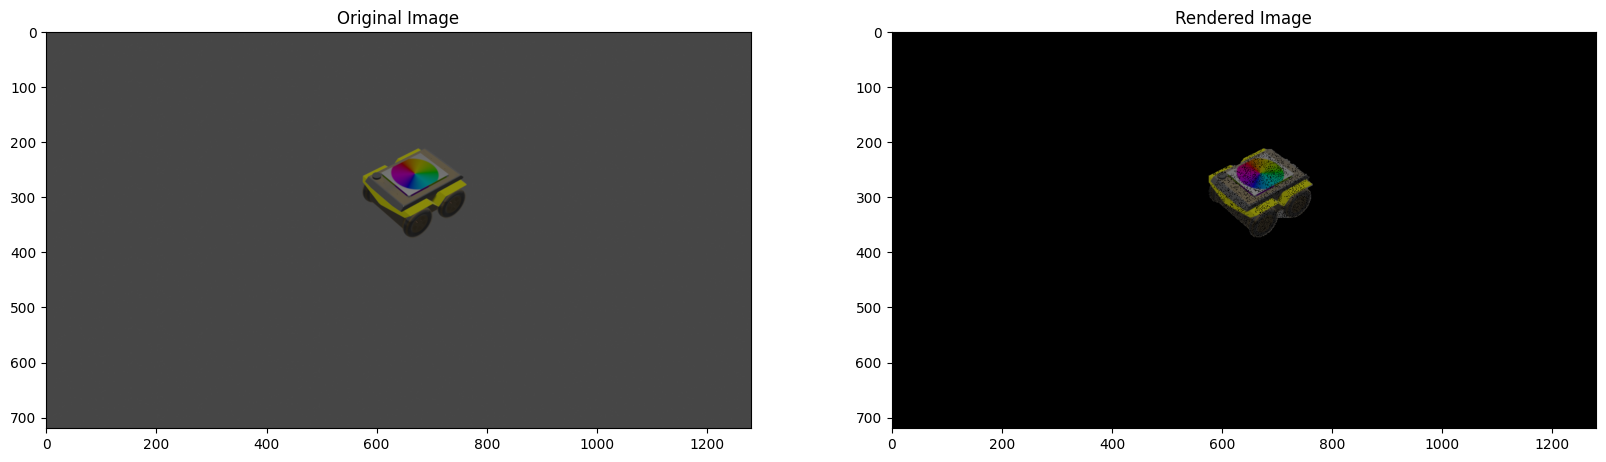

In [30]:
#Plot new_img over original_img
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(original_img)
ax[0].set_title("Original Image")
ax[1].imshow(new_img)
ax[1].set_title("Rendered Image")
plt.show()

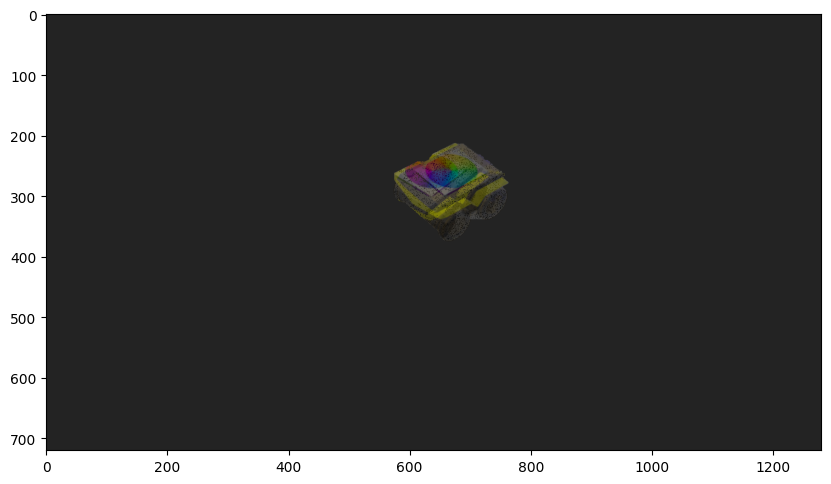

In [9]:
#Overlay original image and rendered image
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(original_img)
ax.imshow(new_img, alpha=0.5)

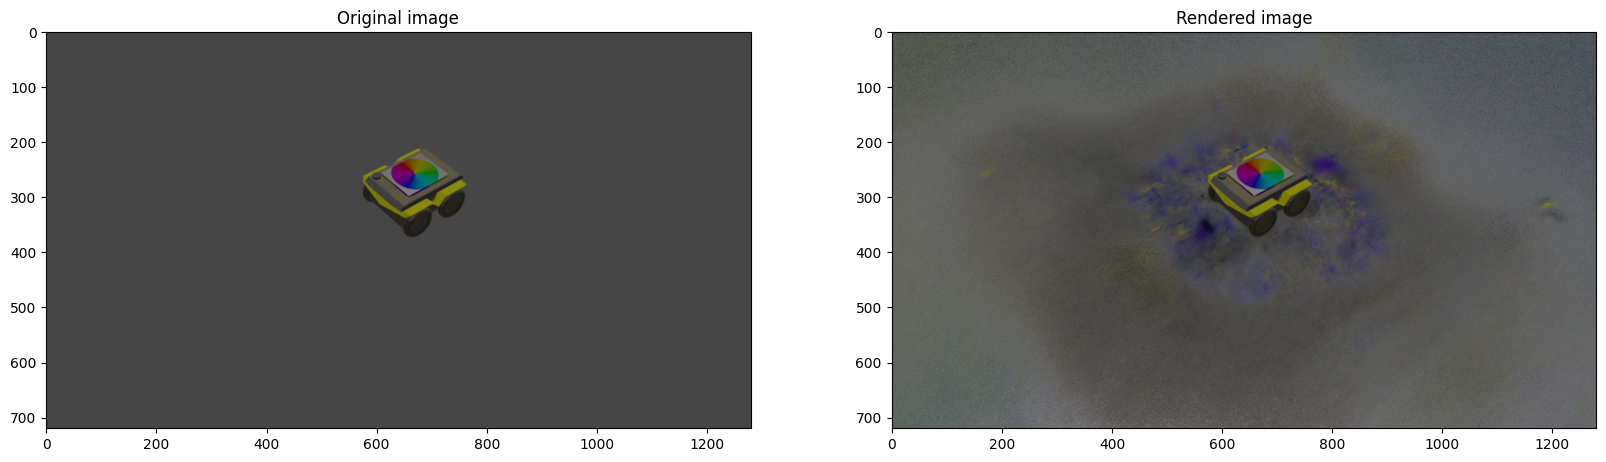

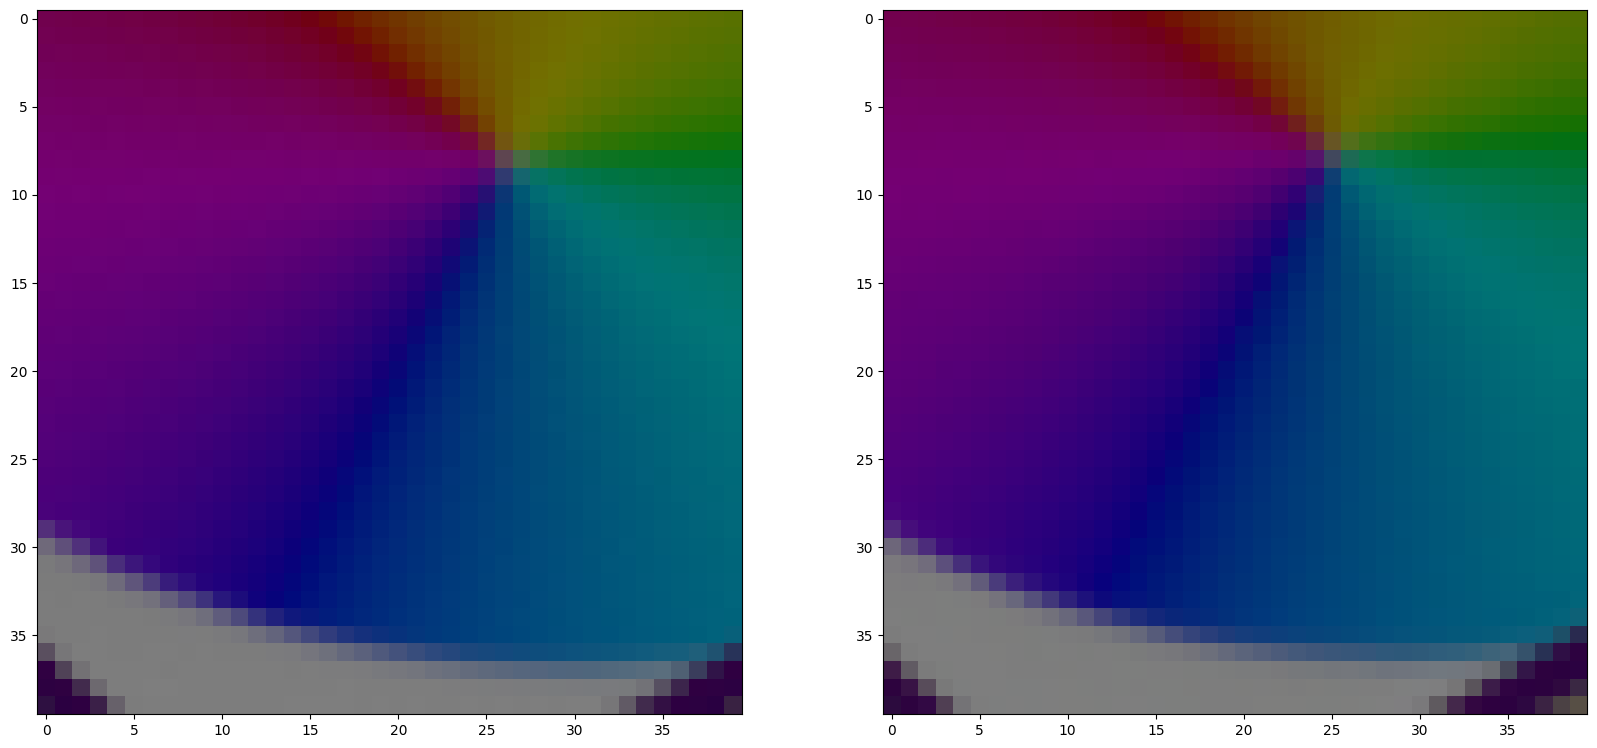

In [10]:
#Plot original image and rendered image
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(original_img)
ax[0].set_title("Original image")
ax[1].imshow(rendered_img)
ax[1].set_title("Rendered image")
#Plot [270,663] and [663,270] pixel in the rendered image
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(original_img[270-20:270+20,663-20:663+20])
ax[1].imshow(rendered_img[270-20:270+20,663-20:663+20])


In [11]:
#cv2.imwrite("rendered_img.png", cv2.cvtColor(rendered_img.detach().numpy()*255, cv2.COLOR_RGB2BGR))